# 01 Loading our custom made functions file

In [6]:
import importlib
import functions
import spectrogram_plotting_functions

importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

<module 'spectrogram_plotting_functions' from 'c:\\Users\\sinha\\Documents\\GitHub\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

## 02 Loading the folder that contains our data

In [7]:
import glob
import getpass
user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat_filtered\\*.mat')
savepath = base+'\\results\\'
print(files)

Hello sinha
['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk1_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk3_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk5_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk6_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230610_dk1_BW_noconte

In [8]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

## 03  Looping through all the data files

[1.75000000e-04 6.75000000e-04 1.17500000e-03 ... 1.48684467e+03
 1.48684517e+03 1.48684567e+03]
(2973692,) (2973692,) 2000
notch filter applied
normalizing data
filtering beta band
filtering gamma band
filtering theta band
[2.75000000e-04 7.75000000e-04 1.27500000e-03 ... 1.48684427e+03
 1.48684477e+03 1.48684527e+03]
(2973691,) (2973691,) 2000
notch filter applied
normalizing data
filtering beta band
filtering gamma band
filtering theta band
[0.0000000e+00 5.0000000e-04 1.0000000e-03 ... 1.4868445e+03 1.4868450e+03
 1.4868455e+03]
(2973692,) (2973692,) 2000
notch filter applied
normalizing data
filtering beta band
filtering gamma band
filtering theta band
[2.50000000e-05 5.25000000e-04 1.02500000e-03 ... 1.48684452e+03
 1.48684502e+03 1.48684552e+03]
(2973692,) (2973692,) 2000
notch filter applied
normalizing data
filtering beta band
filtering gamma band
filtering theta band
{'ref': 2000.0000000000002, 'LFP1_vHp': 2000.0000000000002, 'LFP2_vHp': 2000.0000000000002, 'LFP3_AON': 2000.0

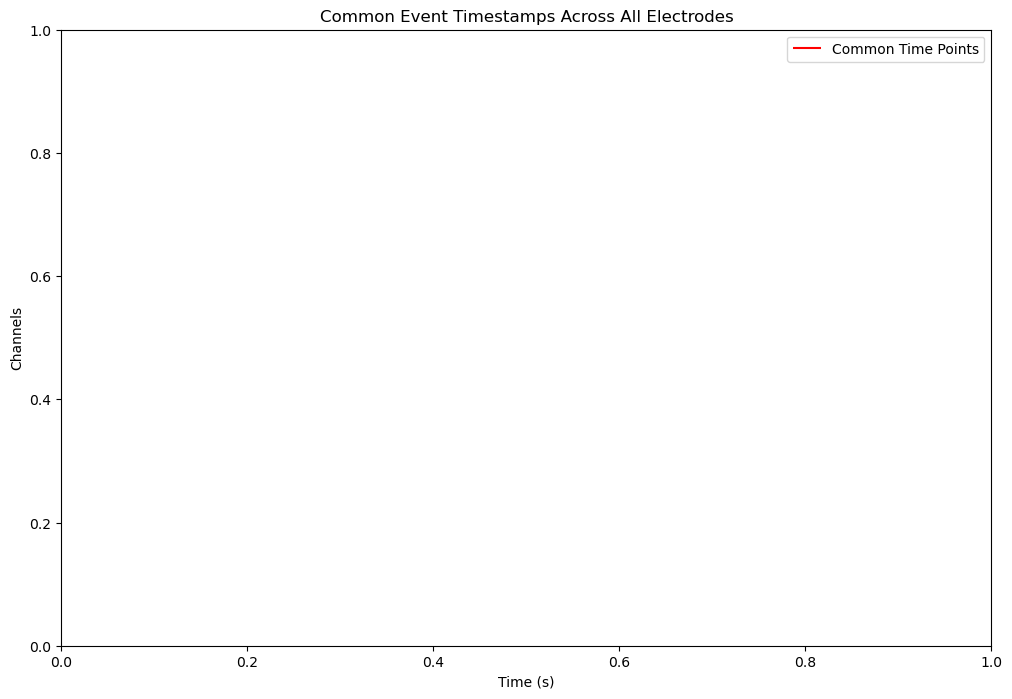

In [10]:
import os
import h5py
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

files = [f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230626_dk5_BW_nocontext_day1.mat']  # This is just for testing purposes
events_codes_all = {}

for file in files:
    # Initialize an empty DataFrame to store the results for all epochs
    compiled_data_all_epochs = pd.DataFrame()
    # Get the date, mouse_id and task from the file name
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)

    date, mouse_id, task = functions.exp_params(base_name)
    # print(date, mouse_id, task)
    # Open the file
    f = h5py.File(file, 'r')
    channels = list(f.keys())
    # print(channels)

    if 'Keyboard' in channels:
        events = f['Keyboard']
    elif 'keyboard' in channels:
        events = f['keyboard']
    elif 'memory' in channels:
        events = f['memory']
    elif 'Memory' in channels:
        events = f['Memory']
    if 'Ref' in channels:
        reference_electrode = f['Ref']
    elif 'ref' in channels:
        reference_electrode = f['ref']
    elif 'REF' in channels:
        reference_electrode = f['REF']

    reference_time = np.array(reference_electrode['times']).flatten()
    reference_value = np.array(reference_electrode['values']).flatten()

    time_freq_dict = {}
    ref_time_freq = (len(reference_time) - 1) / (reference_time[-1] - reference_time[0])
    time_freq_dict['ref'] = ref_time_freq
    events_codes = np.array(events['codes'][0])
    events_times = np.array(events['times'][0])
    events_codes_all[base_name] = events_codes
    # Generating epochs from events (epochs are basically start of a trial and end of a trial)
    epochs = functions.generate_epochs_with_first_event(events_codes, events_times)

    # Experiment Start time
    first_event = events_times[0]

    common_times = None

    for channeli in channels:
        if "AON" in channeli or "vHp" in channeli:

            channel_id = channeli
            # Extracting raw data and time
            data_all = f[channeli]
            raw_data = np.array(data_all['values']).flatten()
            raw_time = np.array(data_all['times']).flatten()

            if common_times is None:
                common_times = raw_time
            else:
                common_times = np.intersect1d(common_times, raw_time)

            print(raw_time)
            time_freq = (len(raw_time) - 1) / (raw_time[-1] - raw_time[0])
            time_freq_dict[channel_id] = time_freq
            sampling_rate = int(1 / data_all['interval'][0][0])
            print(raw_data.shape, raw_time.shape, sampling_rate)
            notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)

            # Normalizing the data by subtracting the mean and std of data 30sec before the first event
            # normalized_data,time,data_before=functions.data_normalization(raw_data,raw_time,first_event, sampling_rate)
            data_before, time, baseline_mean, baseline_std = functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
            normalized_data = functions.zscore_event_data(notch_filtered_data, baseline_mean, baseline_std)
            # Applying a notch filter
            total = normalized_data
            # Extracting the bands
            beta = functions.beta_band(normalized_data, sampling_rate)
            gamma = functions.gamma_band(normalized_data, sampling_rate)
            theta = functions.theta_band(normalized_data, sampling_rate)

            all_bands = [total, beta, gamma, theta]

            for i, epochi in enumerate(epochs):
                compiled_data = pd.DataFrame()

                door_timestamp = epochi[0][0]
                trial_type = epochi[0][1]
                dig_type = epochi[1, 1]
                # print(dig_type)
                dig_timestamp = epochi[1, 0]
                # print(door_timestamp,trial_type,dig_timestamp,dig_type)
                for bandi in all_bands:
                    data_complete_trial = functions.extract_complete_trial_data(bandi, time, door_timestamp, dig_timestamp, sampling_rate)
                    data_trial_before, data_trial_after = functions.extract_door_data(bandi, time, door_timestamp, sampling_rate)
                    data_dig_before, data_dig_after = functions.extract_dig_data(bandi, time, dig_timestamp, sampling_rate)

                    # Create a DataFrame for the current bandi
                    bandi_data = pd.DataFrame({
                        'data_complete_trial': [data_complete_trial],
                        'data_trial_before': [data_trial_before],
                        'data_trial_after': [data_trial_after],
                        'data_dig_before': [data_dig_before],
                        'data_dig_after': [data_dig_after]
                    })

                    # Concatenate the current bandi DataFrame with the compiled_data DataFrame along axis=1
                    compiled_data = pd.concat([compiled_data, bandi_data], axis=1)
                compiled_data.columns = ['total_complete_trial', 'total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor',
                                         'beta_complete_trial', 'beta_pre_door', 'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
                                         'gamma_complete_trial', 'gamma_pre_door', 'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
                                         'theta_complete_trial', 'theta_pre_door', 'theta_post_door', 'theta_pre_odor', 'theta_post_odor']
                compiled_data.insert(0, 'rat', mouse_id)
                compiled_data.insert(1, 'date', date)
                compiled_data.insert(2, 'experiment', task)
                compiled_data.insert(3, 'channel', channel_id)
                compiled_data.insert(4, 'trial', i)
                compiled_data.insert(5, 'timestamps', [[door_timestamp, dig_timestamp]])

                compiled_data.insert(6, 'side', keyboard_dict[str(int(trial_type))])
                compiled_data.insert(7, 'correct?', keyboard_dict[str(int(dig_type))])
                compiled_data.insert(8, 'first 30 seconds power', functions.calculate_power_1D(data_before))
                compiled_data.insert(9, 'time', [time])

                compiled_data_all_epochs = pd.concat([compiled_data_all_epochs, compiled_data], axis=0, ignore_index=True)

print(time_freq_dict)

# Plot the common time points
fig, ax = plt.subplots(figsize=(12, 8))
ax.vlines(common_times, 0, 1, color='r', label='Common Time Points')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channels')
ax.set_title('Common Event Timestamps Across All Electrodes')
ax.legend()
plt.show()

notch filter applied
normalizing data
filtering beta band
filtering gamma band
filtering theta band
notch filter applied
normalizing data
filtering beta band
filtering gamma band
filtering theta band
notch filter applied
normalizing data
filtering beta band
filtering gamma band
filtering theta band
notch filter applied
normalizing data
filtering beta band
filtering gamma band
filtering theta band


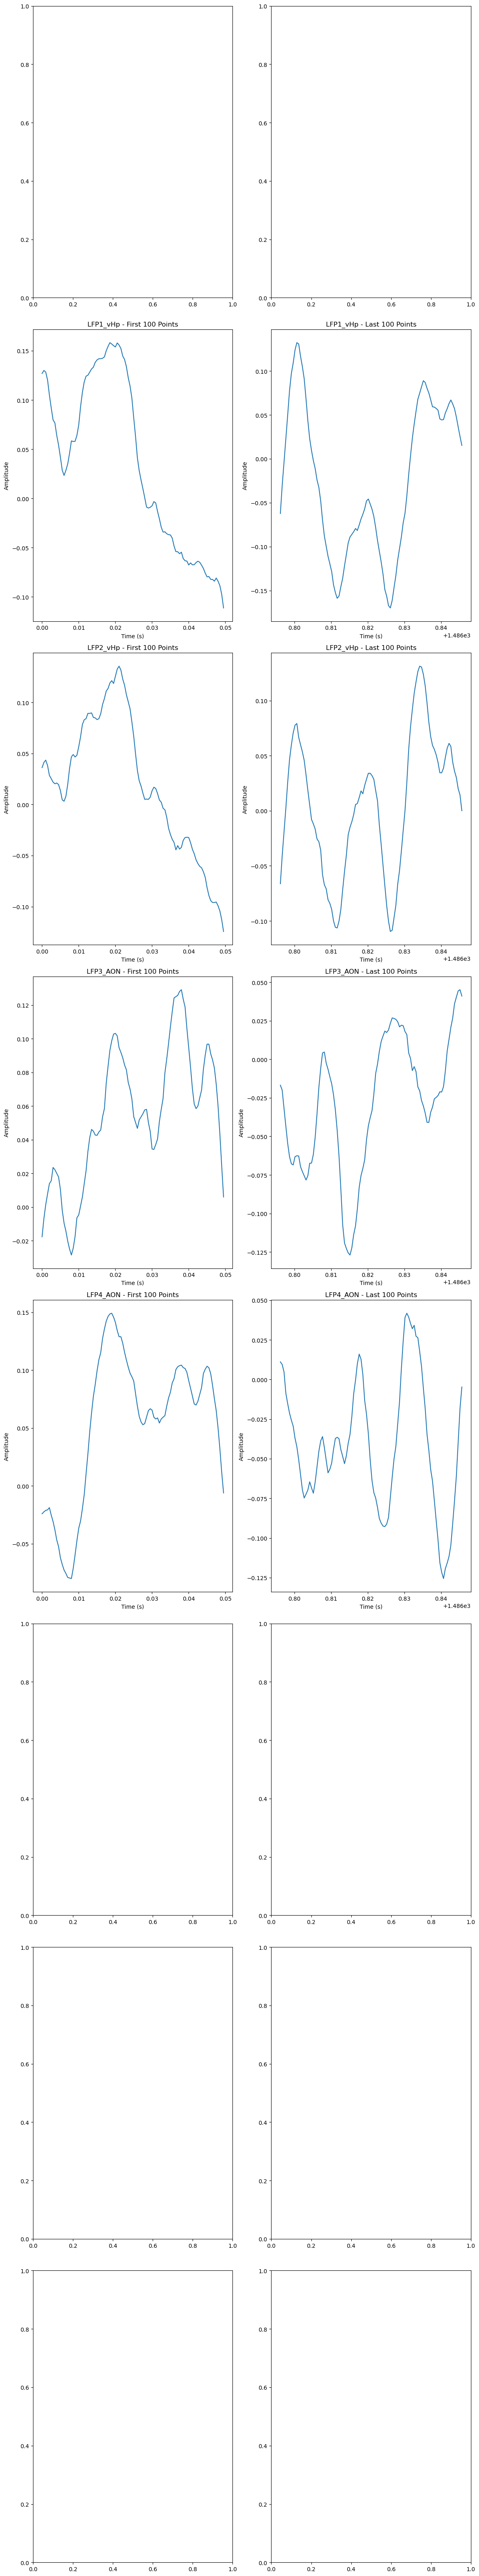

KeyError: "Unable to synchronously open object (object 'values' doesn't exist)"

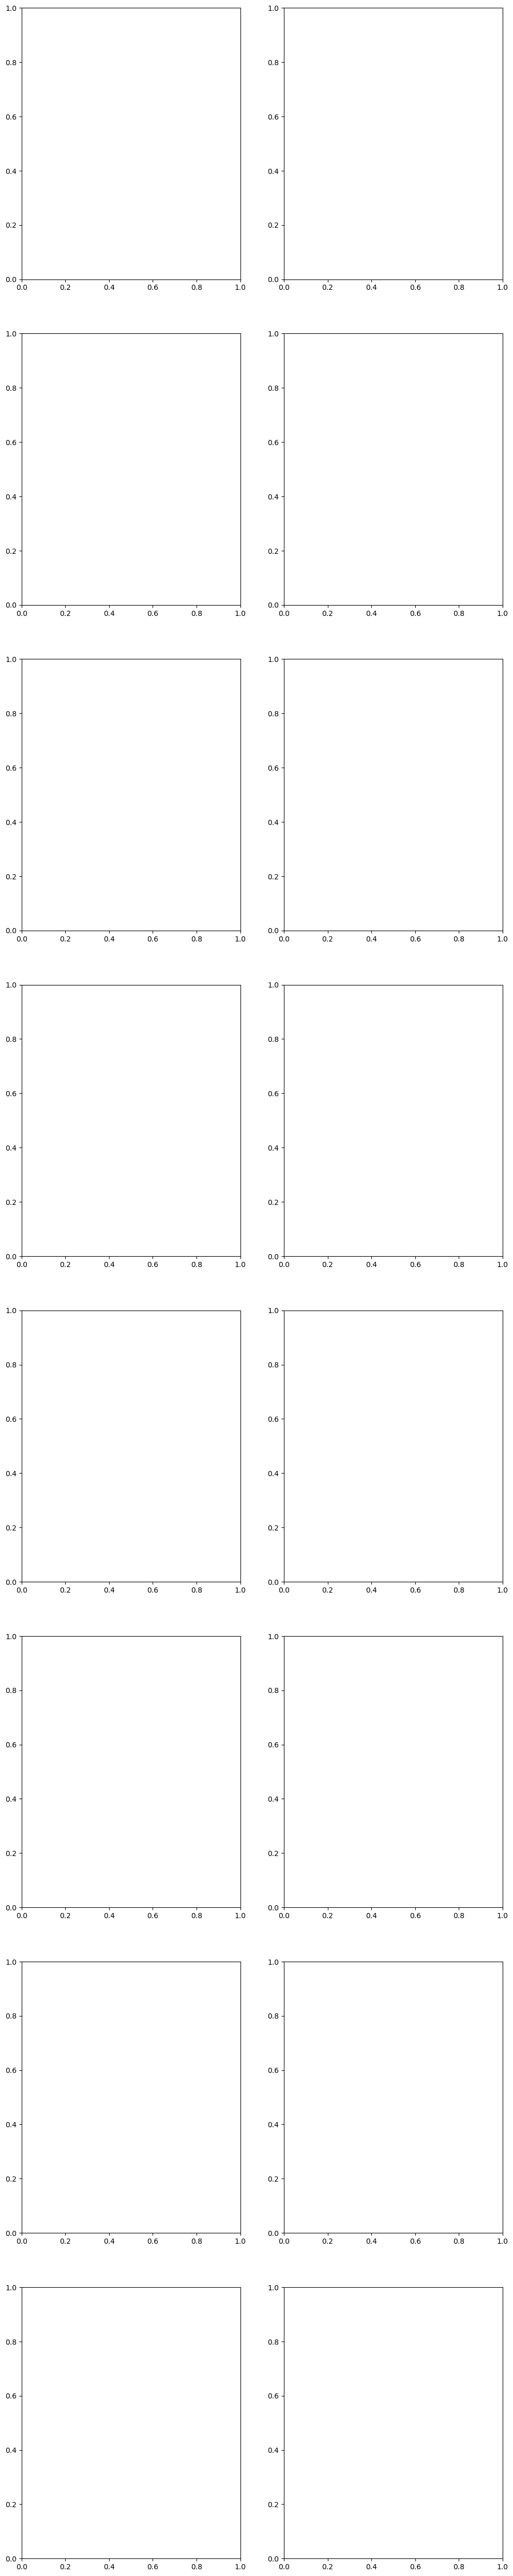

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

files = [f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230626_dk5_BW_nocontext_day1.mat']  # This is just for testing purposes
events_codes_all = {}

for file in files:
    # Initialize an empty DataFrame to store the results for all epochs
    compiled_data_all_epochs = pd.DataFrame()
    # Get the date, mouse_id and task from the file name
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)

    date, mouse_id, task = functions.exp_params(base_name)
    # print(date, mouse_id, task)
    # Open the file
    f = h5py.File(file, 'r')
    channels = list(f.keys())

    keyboard, reference_electrode = functions.get_keyboard_reference_electrode(f,channels)

    reference_time = np.array(reference_electrode['times']).flatten()
    reference_value = np.array(reference_electrode['values']).flatten()

    time_freq_dict = {}
    ref_time_freq = (len(reference_time) - 1) / (reference_time[-1] - reference_time[0])
    time_freq_dict['ref'] = ref_time_freq
    events_codes = np.array(events['codes'][0])
    events_times = np.array(events['times'][0])
    events_codes_all[base_name] = events_codes
    # Generating epochs from events (epochs are basically start of a trial and end of a trial)
    epochs = functions.generate_epochs_with_first_event(events_codes, events_times)

    # Experiment Start time
    first_event = events_times[0]

    global_start_time, global_end_time = functions.find_global_start_end_times(f,channels)
    # Calculate the number of points needed to pad each series
    sampling_rate = 2000  # Assuming a sampling rate of 2000Hz
    total_points = int((global_end_time - global_start_time) * sampling_rate) + 1
    common_time_base = np.linspace(global_start_time, global_end_time, total_points)

    padd_ref_data,padded_ref_time=functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate)

    fig, axs = plt.subplots(len(channels), 2, figsize=(12, 8 * len(channels)))

    for i, channeli in enumerate(channels):
        if "AON" in channeli or "vHp" in channeli:
            channel_id = channeli
            # Extracting raw data and time
            data_all = f[channeli]
            raw_data = np.array(data_all['values']).flatten()
            raw_time = np.array(data_all['times']).flatten()

            padded_data,padded_time=functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)

            # Subtract the reference channel data
            subtracted_data = padded_data - padd_ref_data
            
            # # Pad the data with zeros
            # padded_data = np.zeros(total_points)
            # start_index = int((raw_time[0] - global_start_time) * sampling_rate)
            # end_index = start_index + len(raw_data)
            # padded_data[start_index:end_index] = raw_data
            # # Calculate the amount of padding
            # padding_start = start_index
            # padding_end = total_points - end_index
            # print(f'Channel: {channeli}, Global Start Time: {global_start_time}, Channel Start time : {raw_time[0]}, Global End Time: {global_end_time}, Channel End Time: {raw_time[-1]}')
            # print(f'Channel: {channeli}, Padding Start: {padding_start}, Padding End: {padding_end}')

            #print(raw_time)
            time_freq = (len(raw_time) - 1) / (raw_time[-1] - raw_time[0])
            time_freq_dict[channel_id] = time_freq
            #print(raw_data.shape, raw_time.shape, sampling_rate)
            notch_filtered_data = functions.iir_notch(subtracted_data, sampling_rate, 60)

            # Normalizing the data by subtracting the mean and std of data 30sec before the first event
            data_before, time, baseline_mean, baseline_std = functions.baseline_data_normalization(notch_filtered_data, common_time_base, first_event, sampling_rate)
            normalized_data = functions.zscore_event_data(notch_filtered_data, baseline_mean, baseline_std)
            # Applying a notch filter
            total = normalized_data
            # Extracting the bands
            beta = functions.beta_band(normalized_data, sampling_rate)
            gamma = functions.gamma_band(normalized_data, sampling_rate)
            theta = functions.theta_band(normalized_data, sampling_rate)

            all_bands = [total, beta, gamma, theta]

            for j, epochi in enumerate(epochs):
                compiled_data = pd.DataFrame()

                door_timestamp = epochi[0][0]
                trial_type = epochi[0][1]
                dig_type = epochi[1, 1]
                dig_timestamp = epochi[1, 0]
                for bandi in all_bands:
                    data_complete_trial = functions.extract_complete_trial_data(bandi, time, door_timestamp, dig_timestamp, sampling_rate)
                    data_trial_before, data_trial_after = functions.extract_door_data(bandi, time, door_timestamp, sampling_rate)
                    data_dig_before, data_dig_after = functions.extract_dig_data(bandi, time, dig_timestamp, sampling_rate)

                    # Create a DataFrame for the current bandi
                    bandi_data = pd.DataFrame({
                        'data_complete_trial': [data_complete_trial],
                        'data_trial_before': [data_trial_before],
                        'data_trial_after': [data_trial_after],
                        'data_dig_before': [data_dig_before],
                        'data_dig_after': [data_dig_after]
                    })

                    # Concatenate the current bandi DataFrame with the compiled_data DataFrame along axis=1
                    compiled_data = pd.concat([compiled_data, bandi_data], axis=1)
                compiled_data.columns = ['total_complete_trial', 'total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor',
                                         'beta_complete_trial', 'beta_pre_door', 'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
                                         'gamma_complete_trial', 'gamma_pre_door', 'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
                                         'theta_complete_trial', 'theta_pre_door', 'theta_post_door', 'theta_pre_odor', 'theta_post_odor']
                compiled_data.insert(0, 'rat', mouse_id)
                compiled_data.insert(1, 'date', date)
                compiled_data.insert(2, 'experiment', task)
                compiled_data.insert(3, 'channel', channel_id)
                compiled_data.insert(4, 'trial', j)
                compiled_data.insert(5, 'timestamps', [[door_timestamp, dig_timestamp]])

                compiled_data.insert(6, 'side', keyboard_dict[str(int(trial_type))])
                compiled_data.insert(7, 'correct?', keyboard_dict[str(int(dig_type))])
                compiled_data.insert(8, 'first 30 seconds power', functions.calculate_power_1D(data_before))
                compiled_data.insert(9, 'time', [time])

                compiled_data_all_epochs = pd.concat([compiled_data_all_epochs, compiled_data], axis=0, ignore_index=True)

            # Plot the first 100 data points
            axs[i, 0].plot(common_time_base[:100], padded_data[:100])
            axs[i, 0].set_title(f'{channeli} - First 100 Points')
            axs[i, 0].set_xlabel('Time (s)')
            axs[i, 0].set_ylabel('Amplitude')

            # Plot the last 100 data points
            axs[i, 1].plot(common_time_base[-100:], padded_data[-100:])
            axs[i, 1].set_title(f'{channeli} - Last 100 Points')
            axs[i, 1].set_xlabel('Time (s)')
            axs[i, 1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


# Create another figure for compiled data all epochs
fig2, axs2 = plt.subplots(len(channels), 2, figsize=(12, 8 * len(channels)))

for i, channeli in enumerate(channels):
    if channeli == 'reference_values' or channeli == 'reference_time':
        continue

    if channeli == 'reference_values':
        raw_data = reference_value
        raw_time = reference_time
    elif channeli == 'reference_time':
        raw_data = reference_time
        raw_time = reference_time
    else:
        data_all = f[channeli]
        raw_data = np.array(data_all['values']).flatten()
        raw_time = np.array(data_all['times']).flatten()

    # Pad the data with zeros
    padded_data = np.zeros(total_points)
    start_index = int((raw_time[0] - global_start_time) * sampling_rate)
    end_index = start_index + len(raw_data)
    padded_data[start_index:end_index] = raw_data

    # Subtract the reference channel data
    reference_padded_data = np.zeros(total_points)
    reference_start_index = int((reference_time[0] - global_start_time) * sampling_rate)
    reference_end_index = reference_start_index + len(reference_value)
    reference_padded_data[reference_start_index:reference_end_index] = reference_value

    subtracted_data = padded_data - reference_padded_data

    # Plot the original channel data
    axs2[i, 0].plot(common_time_base, padded_data)
    axs2[i, 0].set_title(f'{channeli} - Original')
    axs2[i, 0].set_xlabel('Time (s)')
    axs2[i, 0].set_ylabel('Amplitude')

    # Plot the channel data after subtracting the reference channel
    axs2[i, 1].plot(common_time_base, subtracted_data)
    axs2[i, 1].set_title(f'{channeli} - Subtracted')
    axs2[i, 1].set_xlabel('Time (s)')
    axs2[i, 1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [9]:
print(reference_electrode)
for i in reference_electrode.keys():
    print(i)
    print(reference_electrode[i])
    unraveled_data = np.array(reference_electrode[i]).flatten()
    print(unraveled_data)
print(reference_electrode['times'])
print(reference_electrode['values'])

<HDF5 group "/Ref" (10 members)>
comment
<HDF5 dataset "comment": shape (2,), type "<u8">
[0 0]
interval
<HDF5 dataset "interval": shape (1, 1), type "<f8">
[0.0005]
length
<HDF5 dataset "length": shape (1, 1), type "<f8">
[2973691.]
offset
<HDF5 dataset "offset": shape (1, 1), type "<f8">
[0.]
scale
<HDF5 dataset "scale": shape (1, 1), type "<f8">
[0.00015259]
start
<HDF5 dataset "start": shape (1, 1), type "<f8">
[0.000375]
times
<HDF5 dataset "times": shape (1, 2973691), type "<f8">
[3.75000000e-04 8.75000000e-04 1.37500000e-03 ... 1.48684437e+03
 1.48684487e+03 1.48684537e+03]
title
<HDF5 dataset "title": shape (3, 1), type "<u2">
[ 82 101 102]
units
<HDF5 dataset "units": shape (2,), type "<u8">
[0 0]
values
<HDF5 dataset "values": shape (1, 2973691), type "<f8">
[ 0.01342773  0.00274658  0.00030518 ... -0.03936768 -0.04348755
 -0.04440308]
<HDF5 dataset "times": shape (1, 2973691), type "<f8">
<HDF5 dataset "values": shape (1, 2973691), type "<f8">


In [11]:
print(raw_time)

[2.50000000e-05 5.25000000e-04 1.02500000e-03 ... 1.48684452e+03
 1.48684502e+03 1.48684552e+03]


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os

# Assuming `files` is the list of files and `functions` contains the necessary functions
files = [f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230626_dk5_BW_nocontext_day1.mat']  # This is just for testing purposes

fig, ax = plt.subplots(figsize=(12, 8))

for file in files:
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)

    date, mouse_id, task = functions.exp_params(base_name)
    print(date, mouse_id, task)

    f = h5py.File(file, 'r')
    channels = list(f.keys())
    print(channels)

    for i, channel in enumerate(channels):
        if "AON" in channel or "vHp" in channel:
            data_all = f[channel]
            raw_time = np.array(data_all['times']).flatten()

            # Plot the timestamps as dashes
            ax.vlines(raw_time, i - 0.4, i + 0.4, color=plt.cm.tab20(i), label=channel)

# Set the y-ticks to the channel names
ax.set_yticks(range(len(channels)))
ax.set_yticklabels([channel for channel in channels if "AON" in channel or "vHp" in channel])

# Add labels and title
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channels')
ax.set_title('Event Timestamps for Each Electrode')

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

20230626 dk5 BWnocontext
['Keyboard', 'LFP1_vHp', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']


KeyboardInterrupt: 

: 

: 

20230626 dk5 BWnocontext
['Keyboard', 'LFP1_vHp', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']


KeyboardInterrupt: 

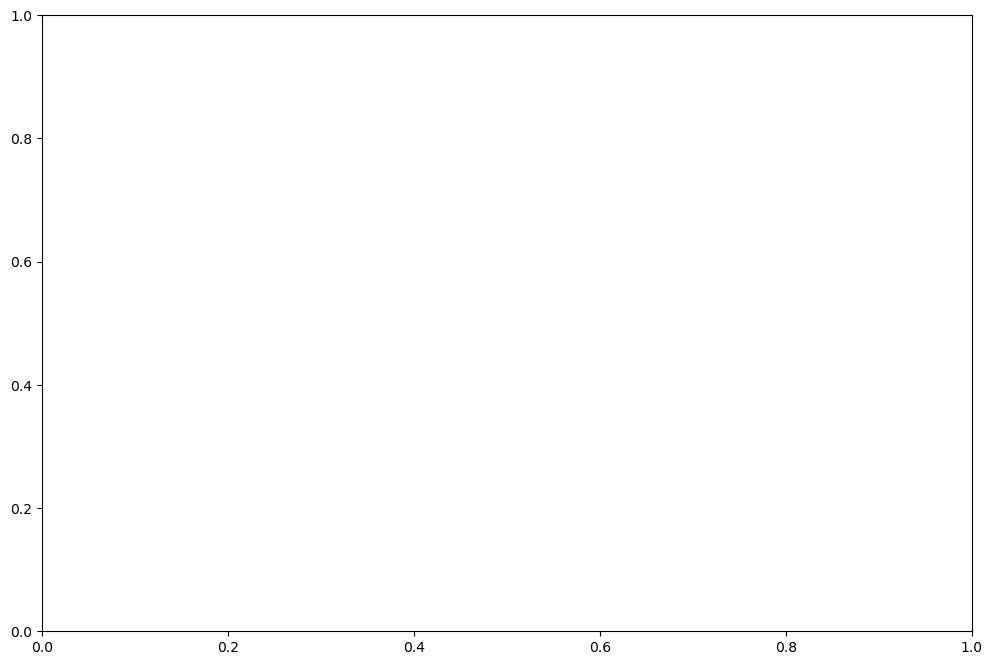

In [4]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import h5py
import os

# Assuming `files` is the list of files and `functions` contains the necessary functions
files = [f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230626_dk5_BW_nocontext_day1.mat']  # This is just for testing purposes

fig, ax = plt.subplots(figsize=(12, 8))

for file in files:
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)

    date, mouse_id, task = functions.exp_params(base_name)
    print(date, mouse_id, task)

    f = h5py.File(file, 'r')
    channels = list(f.keys())
    print(channels)

    lines = []
    colors = []

    for i, channel in enumerate(channels):
        if "AON" in channel or "vHp" in channel:
            data_all = f[channel]
            raw_time = np.array(data_all['times']).flatten()

            # Create line segments for the timestamps
            for t in raw_time:
                lines.append([(t, i - 0.4), (t, i + 0.4)])
                colors.append(plt.cm.tab20(i % 20))

    # Create a LineCollection from the lines and add it to the plot
    line_collection = LineCollection(lines, colors=colors, linewidths=1)
    ax.add_collection(line_collection)

# Set the y-ticks to the channel names
ax.set_yticks(range(len(channels)))
ax.set_yticklabels([channel for channel in channels if "AON" in channel or "vHp" in channel])

# Add labels and title
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channels')
ax.set_title('Event Timestamps for Each Electrode')

plt.show()